In [2]:
# %pip install opencv-python
# %pip install opencv-contrib-python


In [3]:
import cv2
# import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn import cluster
import time
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score


In [4]:
#Premier chargement des images sans ordre, ça a posé problème au moment de retrouver les catégories réelles

# image_paths = glob.glob(os.path.join(path, "*.jpg"))  # prend .jpg, .jpeg, .png
# output_path = "Dataset_projet_pretraitement_textes_images\Flipkart\Preprocessed_Images"
# print(f"{len(image_paths)} images trouvées")


In [5]:
text_df = pd.read_csv(r'Dataset_projet_pretraitement_textes_images\Flipkart\flipkart_com-ecommerce_sample_1050.csv')
text_df.head()


,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [6]:
image_folder = "Dataset_projet_pretraitement_textes_images\Flipkart\Images"

#On veut ordonner les images comme dans le dataset pour pouvoir ensuite récupérer les catégories
image_files = [f"{id}.jpg" for id in text_df['uniq_id']]
image_paths = [os.path.join(image_folder, f) for f in image_files]
# images = [cv2.imread(path, cv2.IMREAD_COLOR) for path in image_paths]
# print(f"{len(images)} images chargées et ordonnées")


## Pré-traitement des données

In [7]:
img_treated = []
for img_path in image_paths:
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.resize(img, (256, 256)) #pour mettre toutes les images à la même taille
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #on passe en niveaux de gris
        eq = cv2.equalizeHist(gray) #on augmente le contraste pour faire ressortir les textures sur les images
        img_treated.append(eq)

img_treated = np.array(img_treated)
print(img_treated.shape)

(1050, 256, 256)


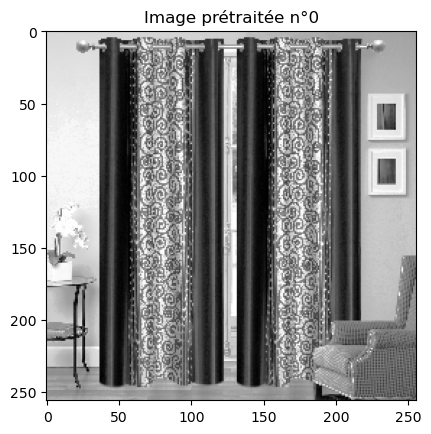

In [8]:
#Pour vérifier mon traitement d'image

plt.imshow(img_treated[0].reshape(256, 256), cmap='gray')
plt.title("Image prétraitée n°0")
plt.show()

## Utilisation de SIFT pour trouver les descripteurs

In [9]:
sift = cv2.SIFT_create()

descriptors_list = []
for eq in img_treated:
    keypoints, descriptors = sift.detectAndCompute(eq, None)
    if descriptors is not None:
        descriptors_list.append(descriptors)

print(len(keypoints))
print(descriptors.shape)


606
(606, 128)


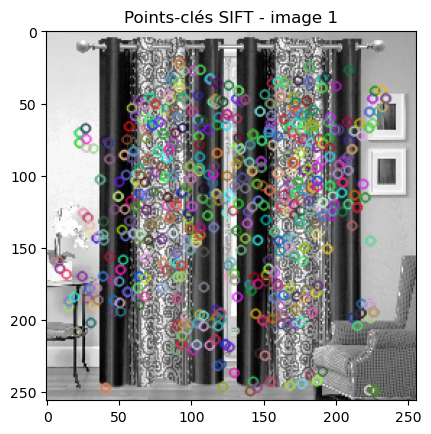

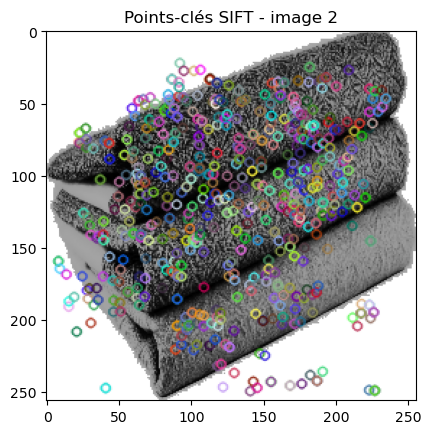

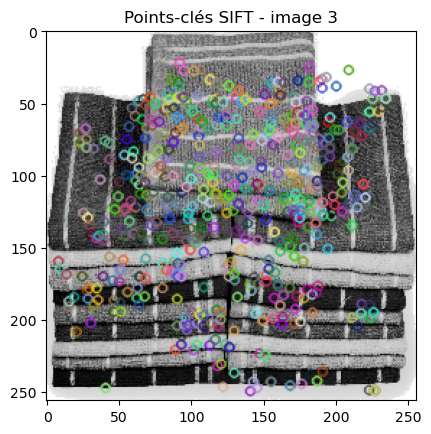

In [10]:
for i in range(3):
    img_kp = cv2.drawKeypoints(img_treated[i], keypoints, None)
    plt.imshow(img_kp, cmap='gray')
    plt.title(f"Points-clés SIFT - image {i+1}")
    plt.show()

## Evaluation de la faisabilité du clustering avec KMeans

In [11]:
all_descriptors = np.concatenate(descriptors_list, axis=0)
df_descriptors = pd.DataFrame(all_descriptors)
print(f"Total descriptors shape: {df_descriptors.shape}")

Total descriptors shape: (423870, 128)


In [12]:
k = int(round(np.sqrt(len(all_descriptors)), 0))
print(f"Nombre de clusters pour KMeans: {k}")
print("Création de",k,"clusters descripteurs SIFT avec KMeans...")

Nombre de clusters pour KMeans: 651
Création de 651 clusters descripteurs SIFT avec KMeans...


In [13]:
kmeans = cluster.MiniBatchKMeans(n_clusters=k, random_state=0, batch_size = 5000)
kmeans.fit(all_descriptors)

,n_clusters,651
,init,'k-means++'
,max_iter,100
,batch_size,5000
,verbose,0
,compute_labels,True
,random_state,0
,tol,0.0
,max_no_improvement,10
,init_size,None
,n_init,'auto'


In [14]:
#Premier essai

# histograms = []

# for desc in descriptors_list:
#     words = kmeans.predict(desc)
#     hist, _ = np.histogram(words, bins=np.arange(k+1), density=True)
#     histograms.append(hist)

# histograms = np.array(histograms)  # shape : nb_images × k
# print(histograms.shape) 

In [15]:
def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist= np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0:print("Problème d'histogramme")
    for i in res:
        hist[i] +=1.0/nb_des
    return hist

In [16]:
histograms = []

for idx, desc in enumerate(descriptors_list):
    if desc is None or len(desc) == 0:
        print(f"Image {idx} n'a pas de descripteurs, histogramme nul.")
        histograms.append(np.zeros(k))
    else:
        hist = build_histogram(kmeans, desc, idx)
        histograms.append(hist)

histograms = np.array(histograms)
print(histograms.shape)  # shape : nb_images × k

(1050, 651)


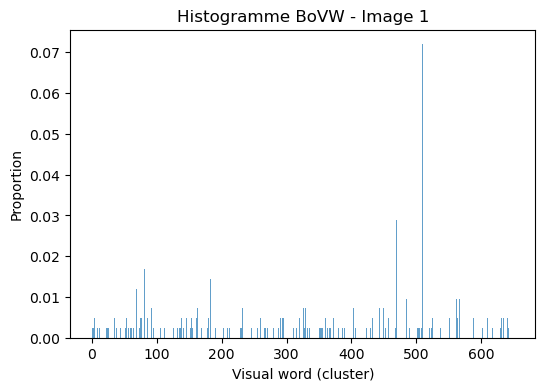

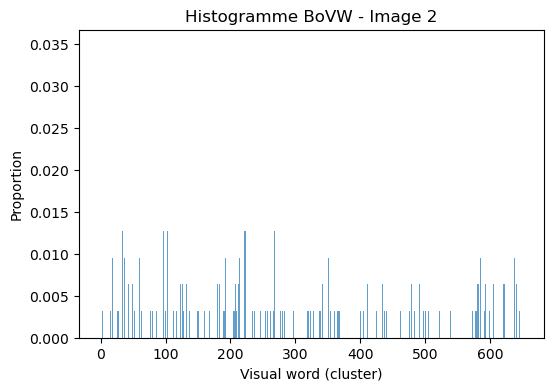

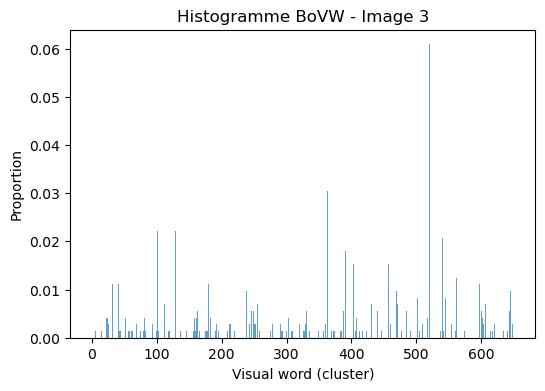

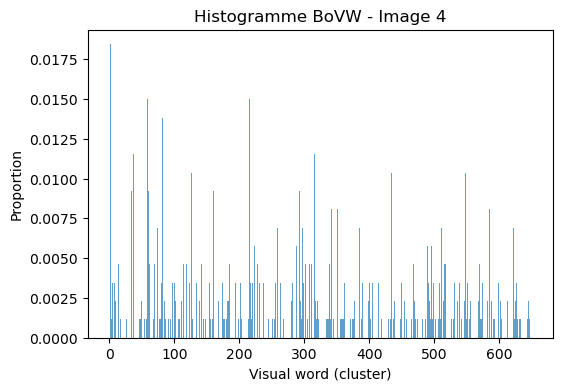

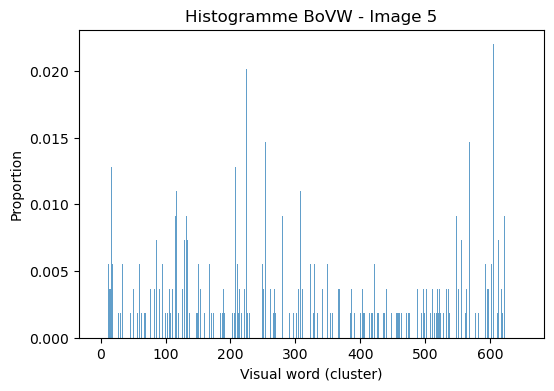

In [17]:
num_to_show = 5  # nombre d’images à illustrer

for i in range(num_to_show):
    plt.figure(figsize=(6,4))
    plt.bar(np.arange(k), histograms[i], alpha=0.7)
    plt.xlabel("Visual word (cluster)")
    plt.ylabel("Proportion")
    plt.title(f"Histogramme BoVW - Image {i+1}")
    plt.show()

In [18]:
df_hist = pd.DataFrame(histograms, columns=[f'Cluster_{i}' for i in range(k)])
print(df_hist.head())

   Cluster_0  Cluster_1  Cluster_2  Cluster_3  Cluster_4  Cluster_5  \
0        0.0   0.002398   0.000000   0.002398   0.004796   0.004796   
1        0.0   0.003175   0.000000   0.003175   0.000000   0.000000   
2        0.0   0.000000   0.000000   0.000000   0.000000   0.000000   
3        0.0   0.003456   0.018433   0.001152   0.000000   0.003456   
4        0.0   0.000000   0.000000   0.000000   0.000000   0.000000   

   Cluster_6  Cluster_7  Cluster_8  Cluster_9  ...  Cluster_641  Cluster_642  \
0   0.000000   0.004796   0.000000   0.002398  ...     0.011990     0.002398   
1   0.000000   0.003175   0.000000   0.000000  ...     0.000000     0.000000   
2   0.001383   0.000000   0.000000   0.000000  ...     0.002766     0.000000   
3   0.000000   0.002304   0.003456   0.002304  ...     0.000000     0.000000   
4   0.000000   0.001832   0.000000   0.000000  ...     0.000000     0.000000   

   Cluster_643  Cluster_644  Cluster_645  Cluster_646  Cluster_647  \
0     0.000000     0.0

In [19]:
pca_img = PCA(n_components=0.99)
pca_img_hist = pca_img.fit_transform(df_hist)
print("Variance expliquée :", pca_img.explained_variance_ratio_)
print("Variance expliquée cumulée :", pca_img.explained_variance_ratio_.sum())

Variance expliquée : [0.09860096 0.05192526 0.03588626 0.02962664 0.02730521 0.02221911
 0.02101507 0.02050163 0.01847717 0.01665509 0.01596098 0.01537002
 0.01421603 0.01341551 0.01229601 0.01161474 0.01104922 0.01020875
 0.00958003 0.00935021 0.00859128 0.00847613 0.00766376 0.00750942
 0.00735853 0.00704781 0.00680398 0.00647108 0.00616863 0.00605312
 0.00596982 0.00581642 0.00552344 0.00536676 0.00516723 0.00508951
 0.0049042  0.00481585 0.00476909 0.00467446 0.00456167 0.00429644
 0.0042002  0.00409771 0.00403749 0.0039946  0.00391507 0.00373331
 0.00371615 0.00364145 0.00348812 0.00344135 0.00336912 0.0033138
 0.00323851 0.00317432 0.00316172 0.00312176 0.0030369  0.00297722
 0.00292208 0.00287119 0.00281752 0.00280994 0.0027852  0.00272973
 0.00269008 0.0026468  0.00259398 0.00255666 0.00249993 0.00248539
 0.00245971 0.00243285 0.00242215 0.00238506 0.00234944 0.00231804
 0.00231563 0.00227243 0.00224827 0.00224562 0.00217319 0.00212884
 0.00212191 0.00207955 0.00204724 0.002034

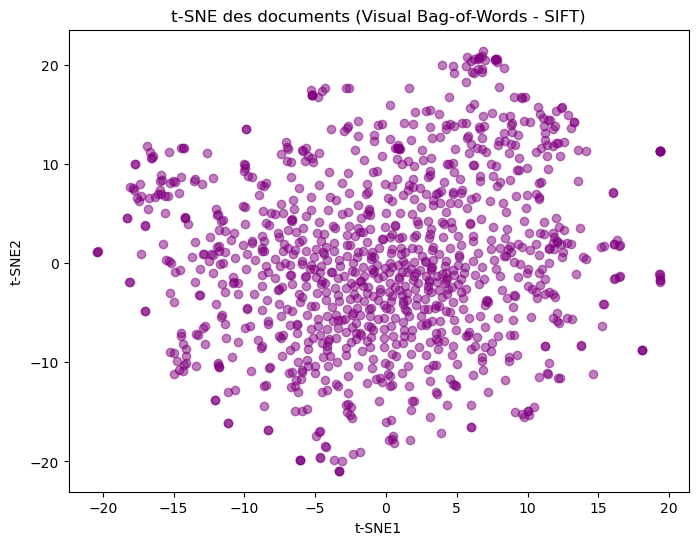

In [20]:
tsne_img = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=30)
tsne_img_hist = tsne_img.fit_transform(pca_img_hist)

df_hist['TSNE1_sift'] = tsne_img_hist[:, 0]
df_hist['TSNE2_sift'] = tsne_img_hist[:, 1]

plt.figure(figsize=(8,6))
plt.scatter(df_hist['TSNE1_sift'], df_hist['TSNE2_sift'], c='purple', alpha=0.5)
plt.title('t-SNE des documents (Visual Bag-of-Words - SIFT)')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.show()

In [21]:
def _normalize_cat_str(x):
    if pd.isna(x):
        return ""
    if isinstance(x, list):
        s = " ".join(map(str, x))
    else:
        s = str(x).strip()
        if s.startswith("[") and s.endswith("]"):
            try:
                parsed = ast.literal_eval(s)
                if isinstance(parsed, list):
                    s = " ".join(map(str, parsed))
            except Exception:
                pass
    s = s.replace("&gt;", ">>").replace("&amp;", "&")
    return s.strip(" []'\"")

def _split_levels(s):
    if not s:
        return []
    if ">>" in s:
        parts = [p.strip() for p in s.split(">>") if p.strip()]
    else:
        parts = [p.strip() for p in re.split(r'\s*>\s*', s) if p.strip()]
    return parts

def extract_first_level(x):
    parts = _split_levels(_normalize_cat_str(x))
    return parts[0] if parts else np.nan

text_df['categories'] = text_df['product_category_tree'].apply(extract_first_level)


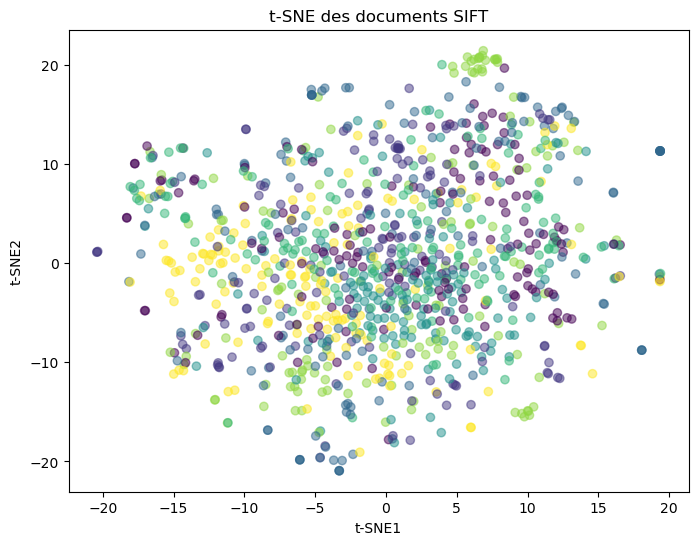

In [22]:
#Pour visualiser suivant les vraies catégories
df_hist['categories'] = text_df['categories']
df_hist['cat_code'] = df_hist['categories'].astype('category').cat.codes

plt.figure(figsize=(8,6))
plt.scatter(df_hist['TSNE1_sift'], df_hist['TSNE2_sift'], c=df_hist['cat_code'], alpha=0.5)
plt.title('t-SNE des documents SIFT')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.show()

La méthode SIFT ne smeble pas donner de résultat concluant pour regrouper les articles par catégories réelles suivant les photos. Je vais faire un essai avec un clustering K-means avec 7 clusters comme les 7 catégories réelles. 

In [23]:
X_tsne = df_hist[['TSNE1_sift', 'TSNE2_sift']]

kmeans_sift = KMeans(n_clusters=7, random_state=42)
kmeans_sift.fit(X_tsne)
df_hist['cluster_sift'] = kmeans_sift.labels_

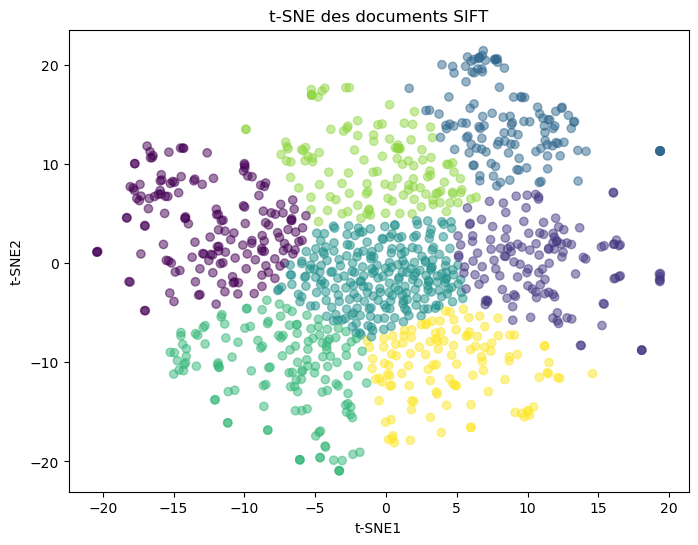

In [24]:
plt.figure(figsize=(8,6))
plt.scatter(df_hist['TSNE1_sift'], df_hist['TSNE2_sift'], c=df_hist['cluster_sift'], alpha=0.5)
plt.title('t-SNE des documents SIFT')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.show()

In [25]:
ari_sift = adjusted_rand_score(df_hist['cluster_sift'], df_hist['cat_code'])
print(f"ARI = {ari_sift:.3f}")

ARI = 0.045


Le score ARI confirme que l'utilisation de SIFT ne permet pas de retrouver les catégories de produits via les images. 

## ORB

In [31]:
orb = cv2.ORB_create(nfeatures=1500) #1500 recommandé pour des image ssimples style e-commerce, on pourrait aussi tester avec 1000

descriptors_list_orb = []
keypoints_list_orb = []

for img in img_treated:
    kp, des = orb.detectAndCompute(img, None)
    keypoints_list_orb.append(kp)

    if des is not None:
        des = des.astype(np.float32)  # obligatoire pour kmeans
        descriptors_list_orb.append(des)

print(len(descriptors_list_orb))

1050


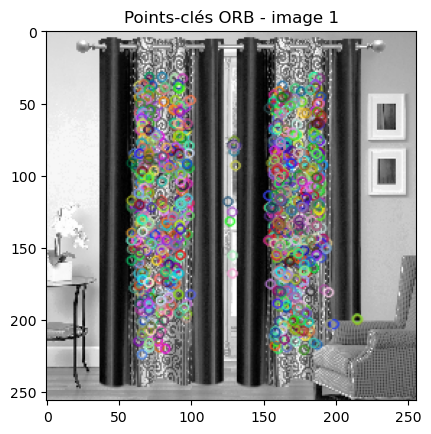

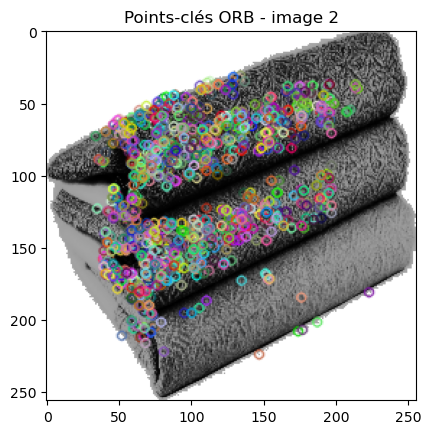

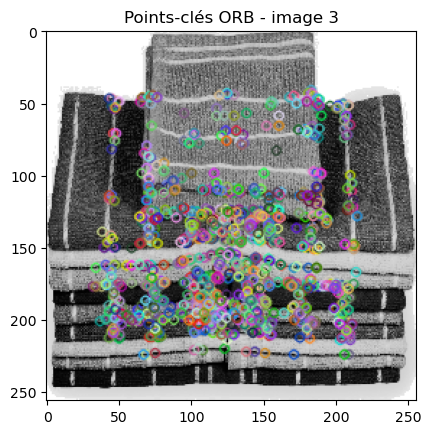

In [27]:
for i in range(3):
    img_kp = cv2.drawKeypoints(img_treated[i], keypoints_list_orb[i], None)
    plt.imshow(img_kp, cmap='gray')
    plt.title(f"Points-clés ORB - image {i+1}")
    plt.show()

In [28]:
orb_descriptors = np.concatenate(descriptors_list_orb, axis=0)


In [29]:
kmeans.fit(orb_descriptors)

,n_clusters,651
,init,'k-means++'
,max_iter,100
,batch_size,5000
,verbose,0
,compute_labels,True
,random_state,0
,tol,0.0
,max_no_improvement,10
,init_size,None
,n_init,'auto'


In [30]:
histograms_orb = []

for idx, desc in enumerate(descriptors_list_orb):
    if desc is None or len(desc) == 0:
        print(f"Image {idx} n'a pas de descripteurs, histogramme nul.")
        histograms_orb.append(np.zeros(k))
    else:
        hist = build_histogram(kmeans, desc, idx)
        histograms_orb.append(hist)

histograms_orb = np.array(histograms_orb)
print(histograms_orb.shape)  # shape : nb_images × k

(1050, 651)


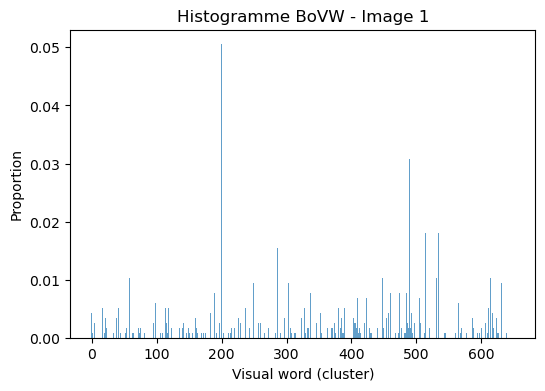

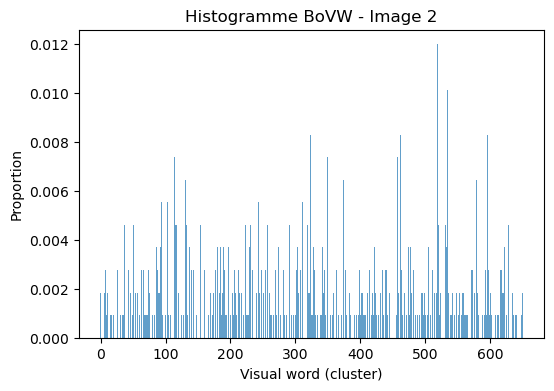

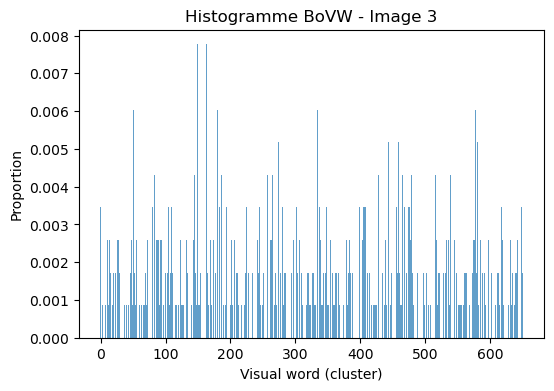

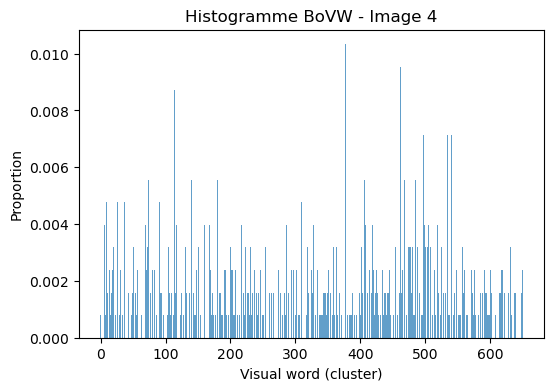

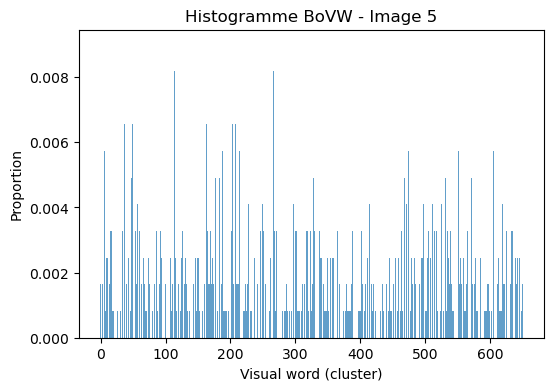

In [32]:
num_to_show = 5  # nombre d’images à illustrer

for i in range(num_to_show):
    plt.figure(figsize=(6,4))
    plt.bar(np.arange(k), histograms_orb[i], alpha=0.7)
    plt.xlabel("Visual word (cluster)")
    plt.ylabel("Proportion")
    plt.title(f"Histogramme BoVW - Image {i+1}")
    plt.show()

In [33]:
df_hist_orb = pd.DataFrame(histograms_orb, columns=[f'Cluster_{i}' for i in range(k)])
print(df_hist_orb.head())

   Cluster_0  Cluster_1  Cluster_2  Cluster_3  Cluster_4  Cluster_5  \
0   0.004281   0.000856   0.000000   0.000000   0.002568   0.000000   
1   0.001843   0.000000   0.001843   0.000000   0.000000   0.001843   
2   0.003451   0.001726   0.002588   0.000863   0.004314   0.001726   
3   0.000794   0.002383   0.001589   0.000000   0.001589   0.000000   
4   0.001638   0.000000   0.003276   0.001638   0.002457   0.000819   

   Cluster_6  Cluster_7  Cluster_8  Cluster_9  ...  Cluster_641  Cluster_642  \
0   0.000000   0.000856   0.000856   0.000000  ...     0.000000     0.000000   
1   0.001843   0.001843   0.002765   0.000922  ...     0.000000     0.000000   
2   0.000000   0.000863   0.000863   0.000000  ...     0.000000     0.002588   
3   0.003971   0.003177   0.000794   0.004766  ...     0.000000     0.000000   
4   0.005733   0.000819   0.000819   0.002457  ...     0.001638     0.002457   

   Cluster_643  Cluster_644  Cluster_645  Cluster_646  Cluster_647  \
0     0.000000     0.0

In [35]:
pca_orb = PCA(n_components=0.99)
pca_img_orb = pca_orb.fit_transform(df_hist_orb)
print("Variance expliquée :", pca_orb.explained_variance_ratio_)
print("Variance expliquée cumulée :", pca_orb.explained_variance_ratio_.sum())

Variance expliquée : [1.58448685e-01 8.38447891e-02 4.73232144e-02 3.87502151e-02
 2.81156407e-02 2.74241541e-02 2.26691330e-02 2.03754784e-02
 1.84423628e-02 1.65503178e-02 1.46107706e-02 1.34657172e-02
 1.04544401e-02 9.96145732e-03 9.06329948e-03 8.55080442e-03
 8.28458161e-03 7.44794900e-03 7.41645104e-03 6.80601836e-03
 6.31062539e-03 5.98481344e-03 5.89388457e-03 5.58177232e-03
 5.34121758e-03 5.02472019e-03 4.93402217e-03 4.83143231e-03
 4.62517958e-03 4.36170663e-03 4.32065685e-03 4.18770542e-03
 4.16379042e-03 3.90898491e-03 3.81625440e-03 3.62502408e-03
 3.59942126e-03 3.50853159e-03 3.43035521e-03 3.29259719e-03
 3.18630338e-03 3.10657882e-03 3.09317401e-03 2.94527227e-03
 2.90691708e-03 2.86949610e-03 2.81392579e-03 2.76322587e-03
 2.74982893e-03 2.72258665e-03 2.68208646e-03 2.57792673e-03
 2.52888972e-03 2.48084409e-03 2.43700642e-03 2.37460159e-03
 2.34351663e-03 2.31765149e-03 2.29421927e-03 2.23503031e-03
 2.19387085e-03 2.15610092e-03 2.13818796e-03 2.09291175e-03
 2.

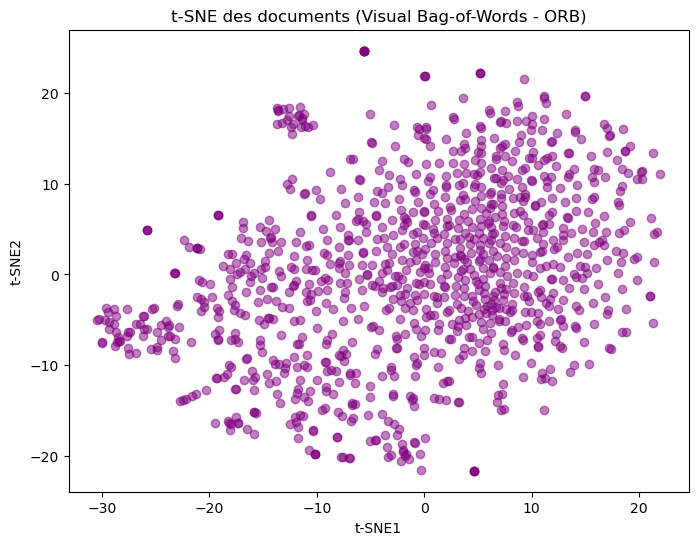

In [39]:
tsne_orb = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=30)
tsne_img_orb = tsne_orb.fit_transform(pca_img_orb)

df_hist_orb['TSNE1_orb'] = tsne_img_orb[:, 0]
df_hist_orb['TSNE2_orb'] = tsne_img_orb[:, 1]

plt.figure(figsize=(8,6))
plt.scatter(df_hist_orb['TSNE1_orb'], df_hist_orb['TSNE2_orb'], c='purple', alpha=0.5)
plt.title('t-SNE des documents (Visual Bag-of-Words - ORB)')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.show()

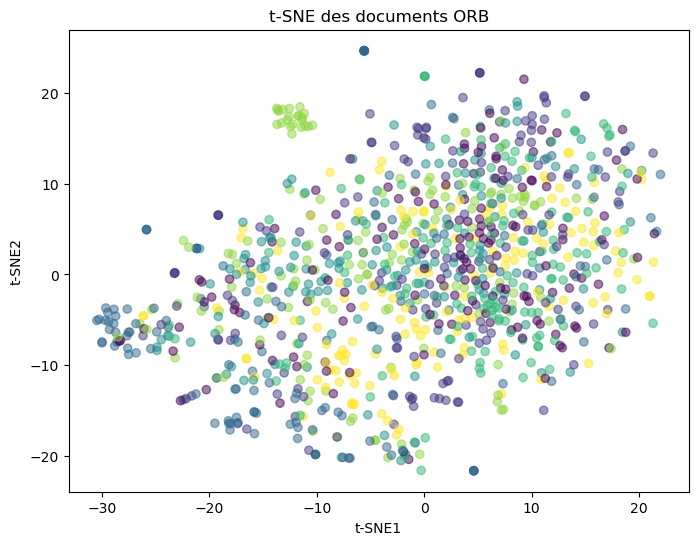

In [40]:
#Pour visualiser suivant les vraies catégories
df_hist_orb['categories'] = text_df['categories']
df_hist_orb['cat_code'] = df_hist_orb['categories'].astype('category').cat.codes

plt.figure(figsize=(8,6))
plt.scatter(df_hist_orb['TSNE1_orb'], df_hist_orb['TSNE2_orb'], c=df_hist_orb['cat_code'], alpha=0.5)
plt.title('t-SNE des documents ORB')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.show()

La méthode ORb ne permet pas de mettre en évidence des clusters facilement identifiables d'après ce graphique. 

In [42]:
X_tsne_orb = df_hist_orb[['TSNE1_orb', 'TSNE2_orb']]

kmeans_orb = KMeans(n_clusters=7, random_state=42)
kmeans_orb.fit(X_tsne_orb)
df_hist_orb['cluster_orb'] = kmeans_orb.labels_

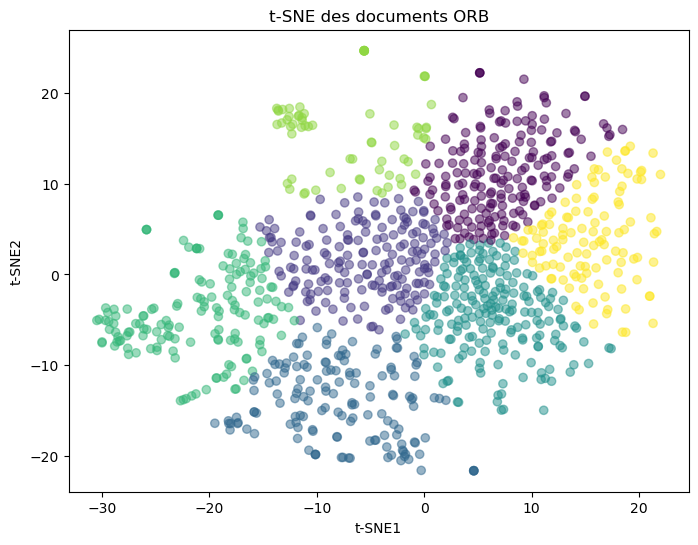

In [44]:
plt.figure(figsize=(8,6))
plt.scatter(df_hist_orb['TSNE1_orb'], df_hist_orb['TSNE2_orb'], c=df_hist_orb['cluster_orb'], alpha=0.5)
plt.title('t-SNE des documents ORB')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.show()

In [46]:
ari_orb = adjusted_rand_score(df_hist_orb['cluster_orb'], df_hist_orb['cat_code'])
print(f"ARI = {ari_orb:.3f}")

ARI = 0.037


Le score ARI confirme que l'utilisation de ORB ne permet pas de retrouver les catégories de produits via les images. 